<a href="https://colab.research.google.com/github/harry-graves/Aria_ORI/blob/main/cnn_epic_kitchens_visor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import os
import json
import zipfile
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!mkdir data
%cd data/
!mkdir false
!mkdir true
%cd ..

!unzip "drive/My Drive/true_right_images.zip" -d data/true
!unzip "drive/My Drive/false_right_images.zip" -d data/false

Streaming output truncated to the last 5000 lines.
  inflating: data/false/P12_101_frame_0000024350.jpg  
  inflating: data/false/P28_103_frame_0000022792.jpg  
  inflating: data/false/P30_05_frame_0000112896.jpg  
  inflating: data/false/P27_101_frame_0000037946.jpg  
  inflating: data/false/P06_102_frame_0000002410.jpg  
  inflating: data/false/P02_03_frame_0000000731.jpg  
  inflating: data/false/P04_05_frame_0000025406.jpg  
  inflating: data/false/P30_111_frame_0000030977.jpg  
  inflating: data/false/P06_102_frame_0000035963.jpg  
  inflating: data/false/P11_16_frame_0000006013.jpg  
  inflating: data/false/P22_01_frame_0000053033.jpg  
  inflating: data/false/P24_08_frame_0000077480.jpg  
  inflating: data/false/P30_05_frame_0000132519.jpg  
  inflating: data/false/P04_101_frame_0000012830.jpg  
  inflating: data/false/P08_21_frame_0000041398.jpg  
  inflating: data/false/P04_121_frame_0000071892.jpg  
  inflating: data/false/P02_102_frame_0000003626.jpg  
  inflating: data/fals

In [8]:
# Load the dataset into tensorflow
data = tf.keras.utils.image_dataset_from_directory('data')

# Scale down the pixel intensitites from 0-255 to 0-1
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

# Partition into training and testing data
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 29703 files belonging to 2 classes.


In [9]:
# Create the CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 483s 731ms/step - accuracy: 0.7450 - loss: 0.5660 - val_accuracy: 0.7681 - val_loss: 0.5071
Epoch 2/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 492s 727ms/step - accuracy: 0.7642 - loss: 0.5028 - val_accuracy: 0.7811 - val_loss: 0.4637
Epoch 3/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 474s 730ms/step - accuracy: 0.8022 - loss: 0.4375 - val_accuracy: 0.7997 - val_loss: 0.4884
Epoch 4/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 475s 732ms/step - accuracy: 0.8428 - loss: 0.3599 - val_accuracy: 0.8093 - val_loss: 0.4744
Epoch 5/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 476s 733ms/step - accuracy: 0.8979 - loss: 0.2435 - val_accuracy: 0.8066 - val_loss: 0.5860
Epoch 6/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 475s 732ms/step - accuracy: 0.9541 - loss: 0.1210 - val_accuracy: 0.7644 - val_loss: 0.9041
Epoch 7/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 476s 733ms/step - accuracy: 0.9773 - loss: 0.0652 - val_accuracy: 0.7497 - val_loss: 0.9913
Epoch 8/20
650/650 ━━━━━━━━━━━━━━━━━━━━ 556s 856ms/step - accuracy: 0.9887 -

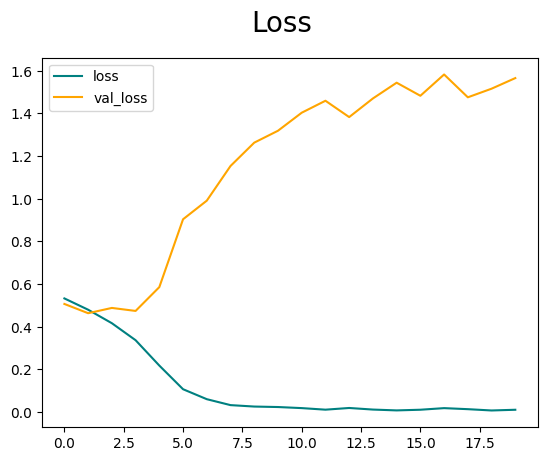

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

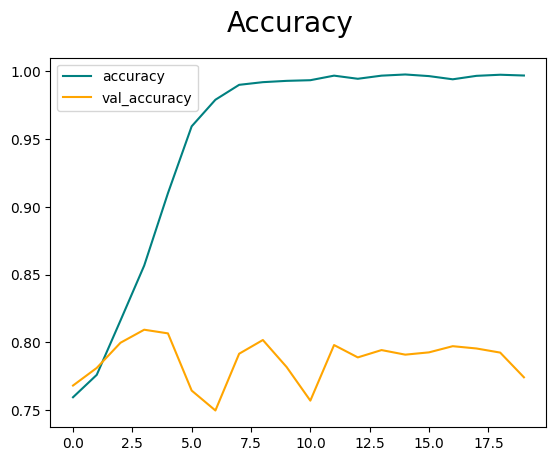

In [13]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    x,y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y,yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

In [ ]:
# See youtube video for the rest of the testing on unseen data
#yhat = model.predict()

In [19]:
# Save the model
models_folder = 'drive/MyDrive/models'
os.makedirs(models_folder, exist_ok=True)

model.save(os.path.join(models_folder, 'right_hand_interaction_detection.keras'))

In [20]:
# Re-load the model
from tensorflow.keras.models import load_model

reloaded_model = load_model(os.path.join(models_folder, 'right_hand_interaction_detection.keras'))

# Can now do the same model.predict()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
